# Cross Stitch Patterns from Images

This code will create a counted cross-stitch pattern from an image by pixellating it, determining color maps and replacing each pixel by an x in the designated color.  One can choose how many different colors to allow for a given image so that it is possible to minimize the complexity.  A color count of stitches will also be reported so the relative amounts of different color threads can be determined.

In [45]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Load image file

In [46]:
import scipy.ndimage as ndi
from scipy.misc import imresize
import requests
from StringIO import StringIO


In [47]:
response = requests.get("http://upload.wikimedia.org/wikipedia/commons/1/1c/CMS_Higgs-event.jpg")
pic = ndi.imread(StringIO(response.content))
print type(pic)

<type 'numpy.ndarray'>


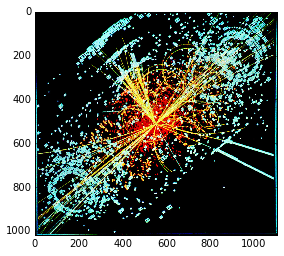

In [48]:
plt.imshow(pic);

In [49]:
print pic.shape
print pic[100,100]

(1018, 1104, 3)
[0 0 0]


Cross-stitching is done with a material called "Aida Cloth".  The size of the weave is measured by how many stitches can be made in one inch. This is called the fabric's count. The most common counts in Aida Cloth are 11, 14, 18 and 28. The higher the number, the smaller the stitches will be, because there are more stitches in each inch. 

For a 20 inch by 20 inch picture, using 14 count Aida Cloth, you have 280 stitches by 280 stitches.  

If you want to reproduce a picture pixel for pixel, divide the number of pixels in a given dimension by the fabric count for the Aida Cloth you intend to use.  That will show you how large the resulting pattern will be.  e.g. for the Higgs event shown above, with 28 count Aida cloth, the image will be 39 x 36 inches - 3 feet by 3 feet.  

In [50]:
#resize image
def resize(image,scale=25):
    """scale = % to resize.  This seems to also convert the 0-1 colors to integer RGB"""
    return imresize(image,scale,mode="RGB")

In [147]:
#count colors
def color_count(image):
    """Considering a (w,h,3) image of (dtype=ubyte),
    compute the number of unique colors\n"""
    F = image[...,0]*256*256 + image[...,1]*256 + image[...,2]
    unique, counts = np.unique(F, return_counts=True)
    return unique, counts

In [124]:
#Found an online RGB<-->DMC floss color conversion table to reference.
def load_floss_colors(example=True):
    values = np.loadtxt('DMCtoRGB_UK.txt', delimiter=' , ',dtype=int, usecols=[0,2,3,4])
    labels = np.loadtxt('DMCtoRGB_UK.txt', delimiter=' , ',dtype=str, usecols=[1,5])
    if example:
        print "Example: ",values[27],labels[27]
    return values,labels

In [148]:
#Use distance in RGB space to determine closest color match
def match_color(rgb):
    """for a given r,g,b tuple, determine the closest DMC thread color"""
    values,labels = load_floss_colors(False)
    #Compute distance to nearest color in RGB space
    rdiff2 = (rgb[0]-values[:,1])**2
    gdiff2 = (rgb[1]-values[:,2])**2
    bdiff2 = (rgb[2]-values[:,3])**2
    cdiff = np.sqrt(rdiff2+gdiff2+bdiff2)
    #print "Input rgb: ",rgb,"\tClosest match:",values[cdiff.argmin()],labels[cdiff.argmin()]
    return values[cdiff.argmin()],labels[cdiff.argmin()]

In [165]:
def floss_color_counts(colors,counts):
    '''print the matched floss colors and counts'''
    mycounts = counts.copy()
    inds = mycounts.argsort()
    sortedcolors = colors[inds].copy()
    mycounts.sort()
    print "Counts\tRGBColor\tMatchedFloss\t\tFlossName"
    print "====================================================================================="
    for i in range(len(counts)-1,-1,-1):
        matches = match_color(sortedcolors[i])
        print mycounts[i],"\t",sortedcolors[i],"\t",matches[0],"\t",matches[1]
    return matches[0][0],mycounts[0]

In [55]:
def aida_size(pic,count=14):
    """Given an Aida cloth count and an image of a given number of pixels,
    report the size of the resulting pattern in inches"""
    x,y,col = pic.shape
    print "Pixel dimensions: (%d x %d)"%(x,y)
    print "Aida Cloth count: %d"%count
    print "Pattern dimensions: (%.2f in x %.2f in)"%(x/float(count),y/float(count))
    print "Pattern colors: %d"%(color_count(pic)[0]).size

In [56]:
def plot_before_after(before,after,text="Transformed"):
    cb = color_count(before)[0].size
    ca = color_count(after)[0].size
    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(1,2,figsize=(12, 6))
    axarr[0].imshow(before)
    axarr[0].set_title('Original image (%d colors)'%cb)
    axarr[1].set_title('%s image (%d colors)'%(text,ca))
    axarr[1].imshow(after);

#First KMeans Algorithm 

In [24]:
#Scikit-learn provides a color reduction algorithm:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html
    
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from time import time

#reduce color count
def reduce_colors(image,n_color=16):
    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1]
    clean = np.array(image, dtype=np.float64) / 255

    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(clean.shape)
    assert d == 3
    image_array = np.reshape(clean, (w * h, d))
    
    #print "Fitting model on a small sub-sample of the data" 
    t0 = time()
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    #print "done in %0.3fs." % (time() - t0)
    
    # Get labels for all points
    #print "Predicting color indices on the full image (k-means)" 
    t0 = time()
    labels = kmeans.predict(image_array)
    #print "done in %0.3fs." % (time() - t0) 
    
    #Recreate the (compressed) image from the kmeans results & labels
    d = kmeans.cluster_centers_.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = kmeans.cluster_centers_[labels[label_idx]]
            label_idx += 1
    return image

#Applied to Data 

## Resize the image

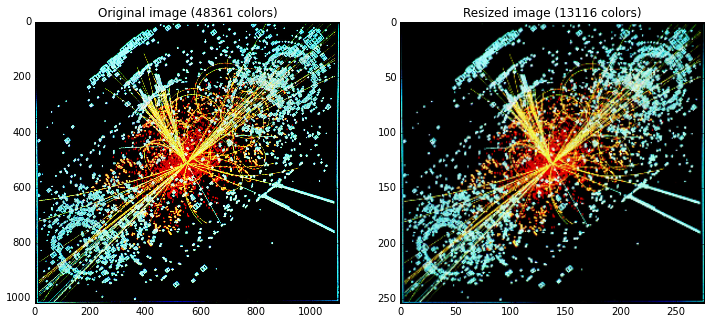

In [57]:
before = pic
after = resize(pic)
plot_before_after(before,after,"Resized")

---

# Second KMeans Algorithm

In [94]:
import scipy as sp
from scipy.cluster.vq import kmeans,vq
from sklearn.utils import shuffle

In [146]:
def reduce_colors2(image, k):
    '''Apply kmeans algorithm.
   Input:  image, number of clusters to use
   Output: colors, counts per color, new image'''
    rows, cols, rgb = image.shape
    # reshape the image in a single row array of RGB pixels
    image_row = np.reshape(image,(rows * cols, 3))
    #HERE ADD CODE TO GET A GOOD GUESS OF COLORS AND PASS THAT AS
    #SECOND ARGUMENT TO kmeans
    #image_array_sample = shuffle(image_row, random_state=0)[:1000]
    #kguess = kmeans(image_array_sample, k)
    #colors,_ = kmeans(image_row, kguess)
    # perform the clustering
    colors,_ = kmeans(image_row, k)
    # vector quantization, assign to each pixel the index of the nearest centroid (i=1..k)
    qnt,_ = vq(image_row,colors)
    # reshape the qnt vector to the original image shape
    image_centers_id = np.reshape(qnt,(rows, cols))
    # assign the color value to each pixel
    newimage = colors[image_centers_id]
    #count number of pixels of each cluster color
    counts,bins = sp.histogram(qnt, len(colors))
    return colors, counts, newimage

## Apply algorithm 2

In [167]:
#Takes a while.  We might try seeding the kmeans with decent guesses, similar to what is done in the first algorithm
colors, counts, after2 = reduce_colors2(after, 24)

In [169]:
print counts.shape

(19,)


In [170]:
#Counts of each color in RGB
smallest = floss_color_counts(colors,counts)

Counts	RGBColor	MatchedFloss		FlossName
42321 	[0 0 0] 	[310   0   0   0] 	['Black' '0x000000']
4174 	[6 3 4] 	[310   0   0   0] 	['Black' '0x000000']
3184 	[164 240 230] 	[996 170 222 225] 	['Electric Blue - MED' '0xAADEE1']
2434 	[211 245 232] 	[827 213 231 232] 	['Blue - VY LT' '0xD5E7E8']
2227 	[120 230 222] 	[996 170 222 225] 	['Electric Blue - MED' '0xAADEE1']
1924 	[232 219  66] 	[973 255 194  67] 	['Canary-BRIGHT' '0xFFC243']
1405 	[213  17   5] 	[900 206  43   0] 	['Burnt Orange - DK' '0xCE2B00']
1308 	[59  9  5] 	[3371   83   37   16] 	['Black Brown' '0x532510']
1229 	[213 133  31] 	[782 204 119  66] 	['Topaz - DK' '0xCC7742']
1210 	[ 5 14 34] 	[939   0   0  49] 	['Navy Blue - VY DK' '0x000031']
1208 	[ 63 215 213] 	[3846   82  173  234] 	['Bright Turquoise - LT' '0x52ADEA']
1124 	[ 42 156 159] 	[3810   59  135  151] 	['Turquoise - DK' '0x3B8797']
1102 	[ 26 102 109] 	[3766   24  101  111] 	['Peacock Blue - LT' '0x18656F']
1011 	[133  19   6] 	[938  99  39  16] 	['Coffee Brow

In [172]:
print smallest
print after2.shape

(3816, 766)
(254, 276, 3)


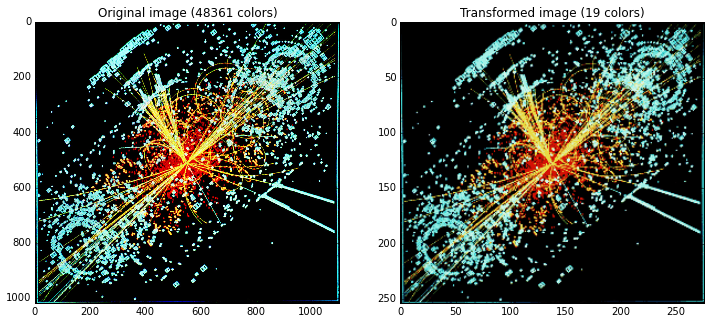

In [173]:
plot_before_after(before,after2)

In [174]:
aida_size(after2,count=14)

Pixel dimensions: (254 x 276)
Aida Cloth count: 14
Pattern dimensions: (18.14 in x 19.71 in)
Pattern colors: 19


Now that I have reduced the number of pixels and the number of colors, I need to represent each color by an ascii character, then create a new 2d array with the character in each array element representing the color of that array element.

In [6]:
# Convertion from text to ASCII codes
def text_to_ASCII():
    message = raw_input("Enter message to encode: ")

    print "Decoded string (in ASCII):"
    for ch in message:
       print ord(ch),
    print "\n\n"

# Convertion from ASCII codes to text
def ASCII_to_text():
    message = raw_input("Enter ASCII codes: ")

    decodedMessage = ""

    for item in message.split():
       decodedMessage += chr(int(item))   

    print "Decoded message:", decodedMessage

In [7]:
text_to_ASCII()

Enter message to encode: foobar
Decoded string (in ASCII):
102 111 111 98 97 114 




In [9]:
ASCII_to_text()

Enter ASCII codes: 102 111 111 98 97 114
Decoded message: foobar


In [10]:
text_to_ASCII()

Enter message to encode: !@#$%^&*()
Decoded string (in ASCII):
33 64 35 36 37 94 38 42 40 41 




##Pattern
1. Choose a set of ASCII characters that look unique from each other.  
2. Assign each one to represent a color in the reduced image.
3. Create a 2-D array whose value at each x-y location is the ASCII code for each character
4. Use a standard 5 mm x 5 mm square for each pixel.  Given the pixel size of the image, determine how many 8.5"x11" pieces of paper would be needed to show the whole image with squares of this size.  
5. Create a set of block grid outlines for the reduced image using the squares and number of sheets determined in step 4.
6. Outline every 10x10 region in a heavier color to ease the counting.
7. Inside each grid block, print the ASCII character associated with the code in the 2-D array.

##Color list
1. Determine the amount of thread per stitch for given Aida cloth sizes.
2. Determine the total number of stitches (pixels) of each color from the color match.
3. Compute the total thread length from 1. and 2. for each color.
4. Add 20% (XX% ??) margin to the total thread length for each color.
5. Use the DMC floss length per spool (6 strands per thread) to determine how many spools are needed, assuming that stitches are done with 2 strands of thread.
6. Print the list of floss colors by name and DMC number, total number of stitches, total length of floss, and number of spools to purchase.